In [3]:
import os
import pickle
import random
import numpy as np
import pandas as pd
from dotenv import load_dotenv

In [ ]:
load_dotenv()
data_dir = os.getenv('DATA_DIR')
proj_dir = os.getenv('PROJ_DIR')

In [11]:
# constants
years = range(2000, 2021)

def get_file_location(year):
    if year < 2011:
        fname = data_dir + 'BRFSS_dataset/{}xpt/CDBRFS{}.XPT'.format(year, str(year)[2:4])
    else:
        fname = data_dir + 'BRFSS_dataset/{}xpt/LLCP{}.XPT'.format(year, year)
    return fname


# Column dictionary
with open(data_dir + 'var_tables.pickle', 'rb') as f:
    [brf_dict, cov_dict] = pickle.load(f)
    
variable_list = list(set([v for v in brf_dict.values()]))

# Re-vamped pre-processing steps

## Part 0: Mapping the correct column names for dependent variables and covariates

In [12]:
# Let's go through the column names over the years:
# match_cols = ['_STATE', 'SEX', '_AGEG5YR', '_EDUCAG', '_INCOMG', '_TOTINDA', '_BMI.?CAT', 
#               '_SMOKER', '_RFSMOK', '_RFBING', '_RFDRHV', '_FL', '_PNEUMO']

column_dict = {}
all_cols = set()

for year in years:
    reader = pd.read_sas(get_file_location(year), iterator=True)
    df = reader.get_chunk(5)
    # get column names for this year
    match_cols = pd.Series([x for x in df.columns if re.match('_', x) is not None])
    # record them into both dictionary and running set union
    column_dict[year] = match_cols
    all_cols = all_cols.union(match_cols)

C:\Users\brian\anaconda3\envs\stat_ml\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


In [13]:
combined_df = pd.DataFrame()
combined_df = pd.concat([pd.Series([0] * len(all_cols), name = x).to_frame() for x in years], axis=1)
combined_df.index = sorted(list(all_cols))
combined_df.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
_AGE65YR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_AGE80,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_AGEG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_AGEG1_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_AGEG2_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
for year in years:
    combined_df.loc[column_dict[year], year] = 1
combined_df.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
_AGE65YR,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
_AGE80,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
_AGEG,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_AGEG1_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_AGEG2_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
combined_df.to_csv(data_dir + '../Table/BRFSS/calculated_rows_by_year.tsv', sep='\t')

## Cell for construction of covariates

I inspected the above file, and decided to do a manual mapping due to some irregularities in how the columns changed over the years:

In [2]:
# dependent variable dictionary
brf_dict = {}
brf_dict['_FLUSHOT'] = 'FLUSHOT' # Flu shot
brf_dict['_FLSHOT2'] = 'FLUSHOT'
brf_dict['_FLSHOT3'] = 'FLUSHOT'
brf_dict['_FLSHOT4'] = 'FLUSHOT'
brf_dict['_FLSHOT5'] = 'FLUSHOT'
brf_dict['_FLSHOT6'] = 'FLUSHOT'
brf_dict['_FLSHOT7'] = 'FLUSHOT'
brf_dict['_FRTINDX'] = 'FRUIT_inv' # fruit index changed
brf_dict['_FRTLT1'] = 'FRUIT' # fruit eating
brf_dict['_FRTLT1A'] = 'FRUIT'
brf_dict['_VEGLT1'] = 'VEGE' # vegetable eating
brf_dict['_VEGLT1A'] = 'VEGE'
brf_dict['_HCVU651'] = 'HTCARE' # health coverage
brf_dict['_HCVU65'] = 'HTCARE'
brf_dict['_PNEUMOC'] = 'PNEUMO' # pneumonia vaccine
brf_dict['_PNEUMO2'] = 'PNEUMO'
brf_dict['_PNEUMO3'] = 'PNEUMO'
brf_dict['_RFBINGE'] = 'RFBING' # binge drinking
brf_dict['_RFBING2'] = 'RFBING'
brf_dict['_RFBING3'] = 'RFBING'
brf_dict['_RFBING4'] = 'RFBING'
brf_dict['_RFBING5'] = 'RFBING'
brf_dict['_RFDRHVY'] = 'RFDRHV' # heavy drinking
brf_dict['_RFDRHV2'] = 'RFDRHV'
brf_dict['_RFDRHV3'] = 'RFDRHV'
brf_dict['_RFDRHV4'] = 'RFDRHV'
brf_dict['_RFDRHV5'] = 'RFDRHV'
brf_dict['_RFDRHV6'] = 'RFDRHV'
brf_dict['_RFDRHV7'] = 'RFDRHV'
brf_dict['_RFSMOK2'] = 'RFSMOK' # smoking
brf_dict['_RFSMOK3'] = 'RFSMOK'
brf_dict['_SMOKER2'] = 'SMOKER' # smoker categories
brf_dict['_SMOKER3'] = 'SMOKER'
brf_dict['_TOTINDA'] = 'TOTINDA' # exercise
brf_dict['SLEPTIME'] = 'SLEPTIM' # sleep amount
brf_dict['SLEPTIM1'] = 'SLEPTIM' # sleep amount

# covariates dictionary
cov_dict = {}
cov_dict['_AGEG5YR'] = '_AGEG5YR' # age
cov_dict['_ASTHMST'] = '_ASTHM' # asthma
cov_dict['_ASTHMS1'] = '_ASTHM'
# cov_dict['_BMI2'] = '_BMI' # bmi
# cov_dict['_BMI3'] = '_BMI'
# cov_dict['_BMI4'] = '_BMI'
# cov_dict['_BMI5'] = '_BMI'
cov_dict['_RFBMI2'] = '_BMICAT' # bmi category - changes over the years
cov_dict['_RFBMI3'] = '_BMICAT'
cov_dict['_RFBMI4'] = '_BMICAT'
cov_dict['_RFBMI5'] = '_BMICAT'
cov_dict['_CHLDCNT'] = '_CHLDCNT' # number of children
cov_dict['_EDUCAG'] = '_EDUCAG' # education
cov_dict['_HISPANC'] = '_HISPANC' # hispanic
cov_dict['_INCOMG'] = '_INCOMG' # income
# cov_dict['_MRACE'] = '_MRACE' # will only code white vs. non-white
# cov_dict['_MRACE1'] = '_MRACE'
cov_dict['_PRACE'] = '_RACE' # will only code white vs. non-white
cov_dict['_PRACE1'] = '_RACE'
cov_dict['_RFCHOL'] = '_RFCHOL' # high cholesterol
cov_dict['_RFCHOL1'] = '_RFCHOL'
cov_dict['_RFCHOL2'] = '_RFCHOL'
cov_dict['_RFHLTH'] = '_RFHLTH' # good health
cov_dict['_RFHYPE2'] = '_RFHYPE' # high blood pressure
cov_dict['_RFHYPE3'] = '_RFHYPE'
cov_dict['_RFHYPE4'] = '_RFHYPE'
cov_dict['_RFHYPE5'] = '_RFHYPE'
cov_dict['_SEXG_'] = '_SEX' # sex
cov_dict['_SEX'] = '_SEX'
cov_dict['SEX'] = '_SEX'
cov_dict['SEX1'] = '_SEX'
cov_dict['_STATE'] = '_STATE' # residency state


In [5]:
# also save these dicts in a pickle dump
with open('../../../Data/var_tables.pickle', 'wb') as f:
    pickle.dump([brf_dict, cov_dict], f)

## Part 1: Building pandas dataframes for each dep. varianble, and for all covariates

In [7]:
fname = data_dir + '2020xpt/LLCP2020.XPT'
df = pd.read_sas(fname)
# obtain brf and cov columns
year_brf_table = df[[x for x in df.columns if x in brf_dict]]
year_cov_table = df[[x for x in df.columns if x in cov_dict]]

In [8]:
year = 2020
# rename columns and indexes
year_brf_table.columns = [brf_dict[x] for x in year_brf_table.columns]
year_brf_table.index = [str(year) + '_' + str(i+1) for i in range(year_brf_table.shape[0])]
year_cov_table.columns = [cov_dict[x] for x in year_cov_table.columns]
year_cov_table.index = [str(year) + '_' + str(i+1) for i in range(year_cov_table.shape[0])]

In [9]:
print(year_brf_table.shape)
year_brf_table.head()

(401958, 9)


,SLEPTIM,HTCARE,TOTINDA,SMOKER,RFSMOK,RFBING,RFDRHV,FLUSHOT,PNEUMO
2020_1,5.0,2.0,1.0,1.0,2.0,1.0,1.0,NaN,NaN
2020_2,7.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,9.0
2020_3,7.0,9.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0
2020_4,6.0,9.0,2.0,4.0,1.0,1.0,1.0,2.0,2.0
2020_5,7.0,9.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0


In [10]:
print(year_cov_table.shape)
year_cov_table.head(5)

(401958, 12)


,_STATE,_RFHLTH,_ASTHM,_RACE,_HISPANC,_SEX,_AGEG5YR,_BMI,_BMICAT,_CHLDCNT,_EDUCAG,_INCOMG
2020_1,1.0,1.0,1.0,1.0,2.0,2.0,8.0,1660.0,1.0,1.0,4.0,1.0
2020_2,1.0,1.0,2.0,2.0,2.0,2.0,10.0,2918.0,2.0,1.0,4.0,9.0
2020_3,1.0,1.0,3.0,2.0,2.0,2.0,10.0,NaN,9.0,1.0,3.0,5.0
2020_4,1.0,1.0,3.0,1.0,2.0,2.0,13.0,NaN,9.0,1.0,2.0,9.0
2020_5,1.0,1.0,3.0,1.0,2.0,2.0,13.0,2034.0,1.0,1.0,4.0,9.0


(array([2.47800e+04, 2.08132e+05, 1.00581e+05, 2.16680e+04, 4.29900e+03,
        8.00000e+02, 2.18000e+02, 7.40000e+01, 3.80000e+01, 1.10000e+01]),
 array([1202. , 2066.1, 2930.2, 3794.3, 4658.4, 5522.5, 6386.6, 7250.7,
        8114.8, 8978.9, 9843. ]),
 <BarContainer object of 10 artists>)

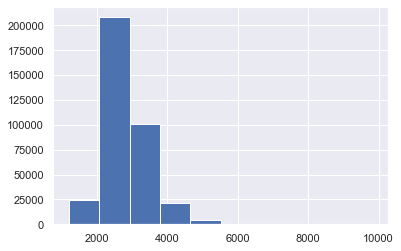

In [12]:
plt.hist(year_cov_table['_BMI'])

In [13]:
max(year_cov_table.loc[year_cov_table['_BMICAT'] == 1, '_BMI'])

2499.0

### - incorporate state abbreviations that match the state FIPS code

In [14]:
# read in a website with state FIPS code:
raw_tbl = pd.read_html('https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm')[0]
state_tbl = pd.concat([raw_tbl.iloc[1:28, 0:3].rename(columns= {0:'state_abbr', 1:'FIPS Code', 2:'state_name'}),
                       raw_tbl.iloc[1:29, 3:6].rename(columns= {3:'state_abbr', 4:'FIPS Code', 5:'state_name'})])
state_tbl['FIPS'] = state_tbl['FIPS Code'].astype('int64')
state_tbl.head()

,state_abbr,FIPS Code,state_name,FIPS
1,AK,02,ALASKA,2
2,AL,01,ALABAMA,1
3,AR,05,ARKANSAS,5
4,AS,60,AMERICAN SAMOA,60
5,AZ,04,ARIZONA,4


In [17]:
# save brf and cov tables
year_brf_table = year_brf_table.fillna(9999).astype('int64')
year_brf_table.to_csv('../../../Table/BRFSS/cleaned_brf_{}.tsv'.format(year), sep = '\t', index = False)

year_cov_table = year_cov_table.fillna(9999).astype('int64').merge(right = state_tbl[['FIPS', 'state_abbr']], 
    left_on = '_STATE', right_on = 'FIPS', how = 'left').drop(columns = 'FIPS')
year_cov_table.to_csv('../../../Table/BRFSS/cleaned_cov_{}.tsv'.format(year), sep = '\t', index = False)

In [116]:
# iterate through the years:
for year in years:
    print(year)
    df = pd.read_sas(get_file_location(year))
    # obtain brf and cov columns
    year_brf_table = df[[x for x in df.columns if x in brf_dict]]
    year_cov_table = df[[x for x in df.columns if x in cov_dict]]
    # rename columns and indexes
    year_brf_table.columns = [brf_dict[x] for x in year_brf_table.columns]
    year_brf_table.index = [str(year) + '_' + str(i + 1) for i in range(year_brf_table.shape[0])]
    year_cov_table.columns = [cov_dict[x] for x in year_cov_table.columns]
    year_cov_table.index = [str(year) + '_' + str(i + 1) for i in range(year_cov_table.shape[0])]
    # save brf and cov tables
    year_brf_table = year_brf_table.fillna(9999).astype('int64')
    year_brf_table.to_csv(data_dir + '../Table/BRFSS/cleaned_brf_{}.tsv'.format(year), sep='\t', index=False)

    year_cov_table = year_cov_table.fillna(9999).astype('int64').merge(right=state_tbl[['FIPS', 'state_abbr']],
                                                                       left_on='_STATE', right_on='FIPS',
                                                                       how='left').drop(columns=['FIPS'])
    year_cov_table.to_csv(data_dir + '../Table/BRFSS/cleaned_cov_{}.tsv'.format(year), sep='\t', index=False)



2000


C:\Users\brian\anaconda3\envs\tdi_project\lib\site-packages\pandas\io\sas\sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


## Part 2: Dump cleaned table for each dependent variable with pickle

In [3]:
def brf_process_df(df):
    # Each dataframe has the following format: 
    # first column is the depedent variable
    # last column is the state name
    # all columns in between, _XXX, are the covariates
    var_max_value = {}
    var_max_value['SLEPTIM'] = 24
    var_max_value['SMOKER'] = 4
    var_max_value['_AGEG5YR'] = 13
    var_max_value['_CHLDCNT'] = 6
    var_max_value['_EDUCAG'] = 4
    var_max_value['_INCOMG'] = 5
    var_max_value['_ASTHM'] = 3
    var_max_value['FRUIT_inv'] = 4
    var_set = set(v for v in brf_dict.values()).union(set(v for v in cov_dict.values()))

    for v in var_set:
        if v not in df.columns or v == '_STATE' or v == 'state_abbr':
            continue
        elif v == '_RACE':
            # collapse all non-white into one category for now
            df.loc[(df[v] > 1) & (df[v] <= 8), v] = 2
            df.loc[(df[v] > 8), v] = np.nan
        else:
            df.loc[(df[v] > var_max_value.get(v, 2)), v] = np.nan
    if '_SEX.1' in df.columns:
        df = df.drop(columns = ['_SEX.1'])
    return df

In [6]:
# construct pickle dump for each dependent variable:
variable_list = list(set([v for v in brf_dict.values()]))
N = 10000

# dep_variable = 'TOTINDA'
for dep_variable in variable_list:
    print(dep_variable)
    yr_dfs = []
    for year in years:
        # we can expect ~300k to 450k rows per year, and we have data for a 21-year period
        # for prototyping, let's just pick 10k row per year
        reader = pd.read_csv(data_dir + '../Table/BRFSS/cleaned_brf_{}.tsv'.format(year), sep='\t', iterator=True)
        if dep_variable not in reader.get_chunk(5).columns:
            continue
        df_brf = pd.read_csv(data_dir + '../Table/BRFSS/cleaned_brf_{}.tsv'.format(year), sep='\t')
        df_cov = pd.read_csv(data_dir + '../Table/BRFSS/cleaned_cov_{}.tsv'.format(year), sep='\t')
        df = pd.concat([df_brf[[dep_variable]], df_cov], axis=1)
        # define a pre-processing pipeline function
        df = brf_process_df(df)
        df = df.loc[~np.isnan(df[dep_variable]),]
        # add year information to the df
        df['year'] = year
        random.seed(42)
        sub_df = df.sample(min(N, df.shape[0]))
        yr_dfs += [sub_df]
    combined_df = pd.concat(yr_dfs)
    #     print(combined_df.head())
    pickle.dump(combined_df, open(data_dir + 'data_dumps/' + dep_variable + '_' + str(N) + '_peryear.pkl', 'wb'))

RFDRHV
TOTINDA
SMOKER
SLEPTIM
PNEUMO
VEGE
RFSMOK
FLUSHOT
FRUIT
RFBING
FRUIT_inv
HTCARE


In [7]:
combined_df.tail()

,HTCARE,_STATE,_SEX,_RFHLTH,_RFHYPE,_RFCHOL,_ASTHM,_RACE,_AGEG5YR,_BMICAT,_CHLDCNT,_EDUCAG,_INCOMG,state_abbr,year,_HISPANC
300357,1.0,41,1.0,2.0,NaN,NaN,1.0,2.0,5.0,2.0,3.0,3.0,5.0,OR,2020,2.0
318113,1.0,46,2.0,1.0,NaN,NaN,3.0,1.0,4.0,2.0,4.0,4.0,NaN,SD,2020,2.0
151780,1.0,24,2.0,2.0,NaN,NaN,1.0,1.0,7.0,2.0,1.0,4.0,5.0,MD,2020,2.0
93905,1.0,17,1.0,1.0,NaN,NaN,1.0,1.0,3.0,2.0,1.0,4.0,5.0,IL,2020,2.0
62752,1.0,12,2.0,1.0,NaN,NaN,3.0,2.0,4.0,NaN,NaN,3.0,NaN,FL,2020,1.0


## Public policy dataset

In [72]:
# I've also processed two documents: state_policy_spending.tsv and state_policy_tax.tsv
state_spending = pd.read_csv(data_dir + '../Table/state_policy_spending.tsv', sep = '\t', low_memory = False).drop_duplicates(['year','st'])
state_tax = pd.read_csv(data_dir + '../Table/state_policy_tax.tsv', sep = '\t', low_memory = False).drop_duplicates(['year','st'])
state_merged = pd.concat([state_spending, state_tax.iloc[:,3:]], axis = 1).drop(columns=['state'])
state_merged = state_merged.sort_values(by=['st', 'year'])
state_merged.index = [i for i in range(state_merged.shape[0])]
print(state_merged.shape)

(1275, 65)


### CSPP column notes
- combine 'adebtpi', 'adebtpia'
- combine 'aasstpi', 'aasstpia'
- combine 'aincloc3', 'aincloc4'
- combine 'aincstat3', 'aincstat4'
- combine 'ainctot2', 'ainctot3', 'ainctot4'
- combine 'atotpi', 'atotpib', 'atotpic'
- use icigtax, z_cigarette_taxes, iindex: drop cigtax, icigtaxraw
- for each alcohol category (beer, wine & spir): add p, t and tex, drop tav

In [73]:
state_merged['cbeer'] = state_merged[['cbeertex', 'cbeerp','cbeert']].fillna(0).sum(axis=1)
state_merged['cwine'] = state_merged[['cwinetex', 'cwinep','cwinet']].fillna(0).sum(axis=1)
state_merged['cspir'] = state_merged[['cspirtex', 'cspirp','cspirt']].fillna(0).sum(axis=1)
cols_to_drop = ['adebtpia', 'aasstpia', 'aincloc4', 'aincstat4', 'ainctot3', 'ainctot4', 'atotpib', 'atotpic', 
               'cigtax', 'icigtaxraw', 'beer_tax', 'beer_tax_rank', 'spirit_tax', 'spirit_tax_rank',
               'wine_tax', 'wine_tax_rank', 'cbeertav', 'cwinetav', 'cspirtav',
               'cbeertex', 'cbeerp','cbeert', 'cwinetex', 'cwinep','cwinet', 'cspirtex', 'cspirp', 'cspirt']
state_merged = state_merged.drop(cols_to_drop, axis=1)

In [74]:
# Design choice: some entries are NaN separated by two numbers - if so, fill them in with the average
for col in state_merged.columns[2:]:
    for i in range(1, state_merged.shape[0]-1):
        if pd.isna(state_merged.loc[i, col]):
            prev_val = state_merged.loc[i-1, col]
            next_val = state_merged.loc[i+1, col]
            if (state_merged.loc[i-1, 'st'] == state_merged.loc[i+1, 'st']) and (not pd.isna(prev_val) and not pd.isna(next_val)):
                state_merged.loc[i, col] = (prev_val + next_val) / 2
                print('fill:', col, str(state_merged.loc[i-1, 'year']))
                print(prev_val, next_val)

fill: aairpi 2000
0.00757734 0.00813448
fill: aairpi 2002
0.00813448 0.01178328
fill: aairpi 2000
0.00154504 0.00095674
fill: aairpi 2002
0.00095674 0.00082032
fill: aairpi 2000
0.00070652 0.00071157
fill: aairpi 2002
0.00071157 0.00060739
fill: aairpi 2000
0.00289107 0.00331898
fill: aairpi 2002
0.00331898 0.00383998
fill: aairpi 2000
0.00197811 0.00175249
fill: aairpi 2002
0.00175249 0.00174077
fill: aairpi 2000
0.00170113 0.00206963
fill: aairpi 2002
0.00206963 0.00256967
fill: aairpi 2000
0.00021109 0.00025438
fill: aairpi 2002
0.00025438 0.00022733
fill: aairpi 2000
0.00049648 0.00112016
fill: aairpi 2002
0.00112016 0.00048621
fill: aairpi 2000
0.00293853 0.00313871
fill: aairpi 2002
0.00313871 0.0034040999999999
fill: aairpi 2000
0.00134192 0.00089173
fill: aairpi 2002
0.00089173 0.00222386
fill: aairpi 2000
0.00482226 0.00372252
fill: aairpi 2002
0.00372252 0.0040266
fill: aairpi 2000
0.00063639 0.00063979
fill: aairpi 2002
0.00063979 0.00066525
fill: aairpi 2000
0.00093715 0.00

fill: adebtpi 2002
0.19138301 0.18431189
fill: adebtpi 2000
0.12707768 0.1477027
fill: adebtpi 2002
0.1477027 0.17124957
fill: adebtpi 2000
0.14214229 0.15161068
fill: adebtpi 2002
0.15161068 0.14548149
fill: adebtpi 2000
0.18514017 0.17482883
fill: adebtpi 2002
0.17482883 0.16938803
fill: adebtpi 2000
0.13387243 0.14236676
fill: adebtpi 2002
0.14236676 0.14952981
fill: adebtpi 2000
0.17423548 0.17034859
fill: adebtpi 2002
0.17034859 0.16426735
fill: adebtpi 2000
0.13740948 0.15131633
fill: adebtpi 2002
0.15131633 0.15293015
fill: adebtpi 2000
0.1746704 0.16232531
fill: adebtpi 2002
0.16232531 0.18378885
fill: adebtpi 2000
0.1602945 0.16722541
fill: adebtpi 2002
0.16722541 0.19082378
fill: adebtpi 2000
0.1875411 0.18279109
fill: adebtpi 2002
0.18279109 0.1915892
fill: adebtpi 2000
0.21951094 0.23313252
fill: adebtpi 2002
0.23313252 0.22886046
fill: adebtpi 2000
0.27438003 0.28192596
fill: adebtpi 2002
0.28192596 0.30313745
fill: adebtpi 2000
0.1326269 0.15243288
fill: adebtpi 2002
0.15

fill: afcgapi 2000
0.01199659 0.01265493
fill: afcgapi 2002
0.01265493 0.01327497
fill: afcgapi 2000
0.00794508 0.00819908
fill: afcgapi 2002
0.00819908 0.00854681
fill: afcgapi 2000
0.00893459 0.00839523
fill: afcgapi 2002
0.00839523 0.00810306
fill: afcgapi 2000
0.01110976 0.00999007
fill: afcgapi 2002
0.00999007 0.01391818
fill: afcgapi 2000
0.00903455 0.00878738
fill: afcgapi 2002
0.00878738 0.00928242
fill: afcgapi 2000
0.00745015 0.0080768
fill: afcgapi 2002
0.0080768 0.0085302
fill: afcgapi 2000
0.0104497 0.01119418
fill: afcgapi 2002
0.01119418 0.01042723
fill: afcgapi 2000
0.00852278 0.00918569
fill: afcgapi 2002
0.00918569 0.00770153
fill: afcgapi 2000
0.01116539 0.01116943
fill: afcgapi 2002
0.01116943 0.01010265
fill: afcgapi 2000
0.00833437 0.00870744
fill: afcgapi 2002
0.00870744 0.00863475
fill: afcgapi 2000
0.008054 0.00845273
fill: afcgapi 2002
0.00845273 0.00871775
fill: afcgapi 2000
0.01102885 0.01021625
fill: afcgapi 2002
0.01021625 0.00945465
fill: afcgapi 2000
0.0

fill: ahcdpi 2000
0.00492516 0.00473026
fill: ahcdpi 2002
0.00473026 0.00448564
fill: ahcdpi 2000
0.00347229 0.00420048
fill: ahcdpi 2002
0.00420048 0.00404057
fill: ahcdpi 2000
0.00419248 0.00457049
fill: ahcdpi 2002
0.00457049 0.00481166
fill: ahcdpi 2000
0.00206451 0.00254334
fill: ahcdpi 2002
0.00254334 0.00303988
fill: ahcdpi 2000
0.0015774 0.00236202
fill: ahcdpi 2002
0.00236202 0.00262447
fill: ahcdpi 2000
0.00303978 0.00303126
fill: ahcdpi 2002
0.00303126 0.00305368
fill: ahcdpi 2000
0.00318593 0.00247258
fill: ahcdpi 2002
0.00247258 0.00230957
fill: ahcdpi 2000
0.00214466 0.00301893
fill: ahcdpi 2002
0.00301893 0.00381455
fill: ahcdpi 2000
0.00277862 0.00286021
fill: ahcdpi 2002
0.00286021 0.00299203
fill: ahcdpi 2000
0.00484308 0.00486271
fill: ahcdpi 2002
0.00486271 0.00548233
fill: ahcdpi 2000
0.00341393 0.0044853
fill: ahcdpi 2002
0.0044853 0.00465187
fill: ahcdpi 2000
0.00228744 0.00188412
fill: ahcdpi 2002
0.00188412 0.00248258
fill: ahcdpi 2000
0.00268994 0.00267565
fil

fill: aincstat3 2002
0.04836155 0.04807305
fill: aincstat3 2000
0.05585884 0.05283156
fill: aincstat3 2002
0.05283156 0.05750816
fill: aincstat3 2000
0.05725728 0.05236858
fill: aincstat3 2002
0.05236858 0.05316615
fill: aincstat3 2000
0.07206583 0.06838547
fill: aincstat3 2002
0.06838547 0.06812075
fill: aincstat3 2000
0.05308705 0.05374279
fill: aincstat3 2002
0.05374279 0.05361782
fill: aincstat3 2000
0.06525781 0.05443809
fill: aincstat3 2002
0.05443809 0.05863098
fill: aincstat3 2000
0.05263888 0.04898262
fill: aincstat3 2002
0.04898262 0.0499429
fill: aincstat3 2000
0.07074187 0.06230713
fill: aincstat3 2002
0.06230713 0.06516517
fill: aincstat3 2000
0.07175934 0.06604112
fill: aincstat3 2002
0.06604112 0.06413371
fill: aincstat3 2000
0.08158161 0.073894
fill: aincstat3 2002
0.073894 0.0756078
fill: aincstat3 2000
0.05099018 0.04815188
fill: aincstat3 2002
0.04815188 0.04649078
fill: aincstat3 2000
0.06955206 0.06397144
fill: aincstat3 2002
0.06397144 0.06375734
fill: aincstat3 2

fill: alibpi 2000
0.00120096 0.00180407
fill: alibpi 2002
0.00180407 0.00116951
fill: alibpi 2000
0.00097589 0.00095439
fill: alibpi 2002
0.00095439 0.00090635
fill: alibpi 2000
0.00064136 0.00076145
fill: alibpi 2002
0.00076145 0.00070632
fill: alibpi 2000
0.00107895 0.00135264
fill: alibpi 2002
0.00135264 0.00162724
fill: alibpi 2000
0.00126026 0.00130176
fill: alibpi 2002
0.00130176 0.00133913
fill: alibpi 2000
0.00061208 0.00067732
fill: alibpi 2002
0.00067732 0.00079299
fill: alibpi 2000
0.00109758 0.00150113
fill: alibpi 2002
0.00150113 0.00142443
fill: anecpi 2000
0.09106682 0.08326112
fill: anecpi 2002
0.08326112 0.04968933
fill: anecpi 2000
0.00761168 0.0085887999999999
fill: anecpi 2002
0.0085887999999999 0.00828514
fill: anecpi 2000
0.00743347 0.00660879
fill: anecpi 2002
0.00660879 0.0061326
fill: anecpi 2000
0.01067782 0.0081713
fill: anecpi 2002
0.0081713 0.00826019
fill: anecpi 2000
0.0131113 0.01506777
fill: anecpi 2002
0.01506777 0.01408166
fill: anecpi 2000
0.01518644

fill: aparkpi 2002
0.00143725 0.00184404
fill: aparkpi 2000
0.00220482 0.00279138
fill: aparkpi 2002
0.00279138 0.00240391
fill: aparkpi 2000
0.00507819 0.00435757
fill: aparkpi 2002
0.00435757 0.00486995
fill: aparkpi 2000
0.00614472 0.00563159
fill: aparkpi 2002
0.00563159 0.00633815
fill: aparkpi 2000
0.00275558 0.00289567
fill: aparkpi 2002
0.00289567 0.00287941
fill: aparkpi 2000
0.00372388 0.00308285
fill: aparkpi 2002
0.00308285 0.00285944
fill: aparkpi 2000
0.00332624 0.00324345
fill: aparkpi 2002
0.00324345 0.0026302
fill: aparkpi 2000
0.00337365 0.00311187
fill: aparkpi 2002
0.00311187 0.00342874
fill: aparkpi 2000
0.00225628 0.00173036
fill: aparkpi 2002
0.00173036 0.00168962
fill: aparkpi 2000
0.00149258 0.00187363
fill: aparkpi 2002
0.00187363 0.00177376
fill: aparkpi 2000
0.00276883 0.00246047
fill: aparkpi 2002
0.00246047 0.00220562
fill: aparkpi 2000
0.00454031 0.00480481
fill: aparkpi 2002
0.00480481 0.00402638
fill: aparkpi 2000
0.00296032 0.00269804
fill: aparkpi 200

fill: asanpi 2002
0.0069418 0.00579292
fill: asanpi 2000
0.00383754 0.00459159
fill: asanpi 2002
0.00459159 0.00404406
fill: asanpi 2000
0.00462442 0.00622696
fill: asanpi 2002
0.00622696 0.00551228
fill: asanpi 2000
0.00343662 0.00358282
fill: asanpi 2002
0.00358282 0.00452008
fill: asanpi 2000
0.00561735 0.00608021
fill: asanpi 2002
0.00608021 0.00433794
fill: asanpi 2000
0.00515997 0.00542249
fill: asanpi 2002
0.00542249 0.00598821
fill: asanpi 2000
0.00549005 0.00484512
fill: asanpi 2002
0.00484512 0.00458054
fill: asanpi 2000
0.0055083999999999 0.004585
fill: asanpi 2002
0.004585 0.00494733
fill: asanpi 2000
0.00638238 0.00597721
fill: asanpi 2002
0.00597721 0.00568683
fill: asanpi 2000
0.00722559 0.0065716
fill: asanpi 2002
0.0065716 0.00680281
fill: asanpi 2000
0.00574826 0.00529915
fill: asanpi 2002
0.00529915 0.00428355
fill: asanpi 2000
0.003665 0.00364851
fill: asanpi 2002
0.00364851 0.00383884
fill: asanpi 2000
0.00406401 0.00357387
fill: asanpi 2002
0.00357387 0.00358225
f

fill: autilpi 2002
0.0214285999999999 0.02239873
fill: autilpi 2000
0.00671201 0.00762814
fill: autilpi 2002
0.00762814 0.00862928
fill: autilpi 2000
0.03572635 0.03548591
fill: autilpi 2002
0.03548591 0.04637864
fill: autilpi 2000
0.01293367 0.01439323
fill: autilpi 2002
0.01439323 0.01517445
fill: autilpi 2000
0.02764825 0.03018069
fill: autilpi 2002
0.03018069 0.02917973
fill: autilpi 2000
0.00722365 0.00748366
fill: autilpi 2002
0.00748366 0.00728509
fill: autilpi 2000
0.01108476 0.01209208
fill: autilpi 2002
0.01209208 0.01028485
fill: autilpi 2000
0.02394389 0.03387909
fill: autilpi 2002
0.03387909 0.02989659
fill: autilpi 2000
0.00713298 0.0074284999999999
fill: autilpi 2002
0.0074284999999999 0.00796278
fill: autilpi 2000
0.00630676 0.00618383
fill: autilpi 2002
0.00618383 0.00663648
fill: autilpi 2000
0.01210103 0.01195239
fill: autilpi 2002
0.01195239 0.01038742
fill: awtpi 2000
0.00194079 0.00135677
fill: awtpi 2002
0.00135677 0.00189432
fill: awtpi 2000
0.00080806 0.0005078

fill: icigtax 2006
2.3807813 2.2292560000000003
fill: icigtax 2008
2.2292560000000003 3.2880797
fill: icigtax 2010
3.2880797 3.1228408
fill: icigtax 2012
3.1228408 3.0286289
fill: icigtax 2006
0.90528472 1.9485349
fill: icigtax 2008
1.9485349 2.7391606
fill: icigtax 2010
2.7391606 2.601507
fill: icigtax 2012
2.601507 2.5230231
fill: icigtax 2006
0.64663194 0.60547693
fill: icigtax 2008
0.60547693 0.59783267
fill: icigtax 2010
0.59783267 0.56778923
fill: icigtax 2012
0.56778923 0.55065981
fill: icigtax 2006
0.70541667 0.66052029
fill: icigtax 2008
0.66052029 0.65218109
fill: icigtax 2010
0.65218109 0.61940643
fill: icigtax 2012
0.61940643 0.60071979
fill: iindex 2006
-0.2961753 0.2854834
fill: iindex 2008
0.2854834 0.2736309
fill: iindex 2010
0.2736309 0.2270485
fill: iindex 2012
0.2270485 0.2004892
fill: iindex 2006
-1.036156 -0.8589911
fill: iindex 2008
-0.8589911 -0.4563363
fill: iindex 2010
-0.4563363 -0.4662350999999999
fill: iindex 2012
-0.4662350999999999 -0.4718789
fill: iindex 

In [71]:
state_merged

,year,st,aairpi,aasstpi,acorrpi,adebtpi,aedpi,aerpi,aesapi,afcgapi,...,autilpi,awtpi,w_environment_solar_taxcredit,fgastax1,icigtax,iindex,z_cigarette_taxes,cbeer,cwine,cspir
0,1995,AK,0.006273,0.066981,0.009206,0.454655,0.096609,0.020922,0.002102,0.028873,...,0.021452,0.001944,0.0,NaN,NaN,NaN,0.40,5.868462,23.850837,58.711396
1,1996,AK,0.007370,0.591879,0.009243,0.427652,0.097510,0.022406,0.001929,0.026845,...,0.019192,0.001395,0.0,NaN,NaN,NaN,0.40,5.854281,23.816396,58.484492
2,1997,AK,0.007105,0.072413,0.009034,0.425230,0.095641,0.024736,0.001797,0.026629,...,0.016321,0.001673,0.0,NaN,NaN,NaN,1.34,5.843508,21.800000,58.312130
3,1998,AK,0.006656,1.851764,0.009001,0.426553,0.087746,0.025812,0.001768,0.026040,...,0.018694,0.003588,0.0,NaN,NaN,NaN,1.31,5.836307,23.772746,58.312957
4,1999,AK,0.008067,0.058922,0.008541,0.410962,0.096329,0.023967,0.001365,0.023595,...,0.016238,0.001448,0.0,NaN,NaN,NaN,1.27,5.826317,23.748485,58.037076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,2015,WY,0.002996,0.765928,0.006429,0.059490,0.086380,0.014869,0.000773,0.014551,...,0.006326,0.000000,NaN,NaN,0.600008,NaN,NaN,5.062168,21.800000,45.200000
1271,2016,WY,NaN,0.780892,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.592532,NaN,NaN,5.044000,21.800000,45.200000
1272,2017,WY,NaN,0.777158,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1273,2018,WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000


In [78]:
state_merged.to_csv(data_dir + '../Table/state_policy_tax_spending_merge.tsv', sep = '\t', index = False)